# Building the Neural Network

## Library Imports

In [1]:
#### KERAS IMPORTS ####
from keras import backend as K
K.set_image_dim_ordering('tf')

import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions, preprocess_input
from keras.applications import InceptionV3, ResNet50
from keras.preprocessing import image
from keras.models import Model

#### SKLEARN IMPORTS ####
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### OTHER IMPORTS ####
import cv2
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import joblib
import re
import skvideo.io
import datetime

# from PIL import ImageGrab
import matplotlib.pyplot as plt
from IPython.display import clear_output

% pylab inline
% matplotlib inline

print("BACKEND: ", keras.backend.backend())

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib
('BACKEND: ', u'tensorflow')


## Functions

In [ ]:
def resize_img(orig_img, new_dim):
    '''
    DESCRIPTION:
        - resizes the original image.
    INPUT: 
        - orig_img is a numpy array (use cv2.imread() to transform img into numpy array).
        - new_dim is the base number of pixels for the new image.
    OUTPUT:
        - resized is a numpy array of the resized image.
    '''
    r = float(new_dim) / orig_img.shape[1]
    dim = (new_dim, int(orig_img.shape[0] * r))
    resized = cv2.resize(orig_img, dim, interpolation=cv2.INTER_AREA)
    
    return resized

In [ ]:
def rotate_img(orig_img, deg_rot, scale):
    '''
    DESCRIPTION:
        - rotates the original image.
    INPUT: 
        - orig_img is a numpy array (use cv2.imread() to transform img into numpy array).
        - scale (btwn 0 and 1) zooms in on the image. scale (> 1) zooms out on the image. 
        - scale can be used to crop the image based only on the center.
    OUTPUT:
        - rotated_img is a numpy array of the rotated image.
    '''
    (height, width) = orig_img.shape[:2]
    center = (width/2, height/2)
    matrix = cv2.getRotationMatrix2D(center,
                                     angle=deg_rot,
                                     scale=scale)
    rotated_img = cv2.warpAffine(orig_img,
                                 matrix,
                                 (width, height))
    
    return rotated_img

In [ ]:
def crop_img(orig_img, h1, h2, w1, w2):
    '''
    DESCRIPTION:
        - crops the original image.
    INPUT: 
        - orig_img is a numpy array (use cv2.imread() to transform img into numpy array).
        - h1 and h2 defines height
        - w1 and w2 defines the width
    OUTPUT:
        - cropped_img is a numpy array of the cropped image.
    '''
    cropped_img = orig_img[h1:h2, w1:w2]

    return cropped_img

In [ ]:
def augment(image_path, repeat=5):
    '''
    DESCRIPTION:
        - randomly augments the image.
    INPUT: 
        - orig_img is a numpy array (use cv2.imread() to transform img into numpy array).
    OUTPUT:
        - new_img is a numpy array of the augmented image.
    '''    
    img_arr = cv2.imread(image_path)
    
    img_paths = []
    
    for i in range(repeat):
        new_dim = int(img_arr.shape[1] * np.random.uniform(low=0.1, high=0.3))
        new_img_arr = resize_img(img_arr, new_dim)

        deg = np.random.randint(15, 345)
        scale = np.random.uniform(low=1, high=4)
        new_img_arr = rotate_img(new_img_arr, deg, scale)

        lower_height = np.random.randint(25, new_img_arr.shape[0])
        lower_width = np.random.randint(25, new_img_arr.shape[1])
        upper_height = np.random.randint(lower_height, 10000)
        upper_width = np.random.randint(lower_width, 10000)

        new_img_arr = crop_img(new_img_arr, h1=lower_height, h2=upper_height, w1=lower_width, w2=upper_width)

        new_img_path = 'data/aug_images/' + 'aug_' + str(i) + "_" + re.sub(r"data/[a-zA-Z]*/", '', image_path)

        new_img = cv2.imwrite(new_img_path, new_img_arr)
        img_paths.append(new_img_path)
        if not new_img:
            print("Check image path: ", new_img_path)
            img_paths.append('')
    
    return img_paths

In [ ]:
def get_clean_aug_arrays(tot_count, files):
    '''
    DESCRIPTION:
        - produces a list of numpy arrays for each image in the files list.
    INPUT: 
        - tot_count is the number of files to traverse through.
        - files is the list of image files.
    OUTPUT:
        - X is the list of numpy arrays for the clean images.
        - X_aug is the list of numpy arrays for the augmented images.
    '''
    X = []
    X_aug = []
    
    if tot_count > len(files):
        print("tot_count exceeds the number of files.")
        return False
    
    for i in range(tot_count):
        # Convert the clean image
        clean_img = image.load_img(files[i], target_size=(224,224))
        clean_img = image.img_to_array(clean_img)
        if clean_img == None:
            continue
        X.append(clean_img)

        # Augment then convert the new image
        temp_imgs = augment(files[i])
        for temp_img in temp_imgs:
            if temp_img == '':
                continue
            else:
                prep_img = image.load_img(temp_img, target_size=(224,224))
                prep_img = image.img_to_array(prep_img)
                if prep_img == None:
                    continue
            X_aug.append(prep_img)

    if len(X) == len(X_aug):
        print("Augmenting worked correctly.")
        
    X = np.array(X)
    X = preprocess_input(X)
    
    X_aug = np.array(X_aug)
    X_aug = preprocess_input(X_aug)
        
    return X, X_aug

In [ ]:
def get_metrics(y_train_pred, y_test_pred, y_train, y_test):
    '''
    DESCRIPTION:
        - Get the various classification metrics for the training and test data.
    INPUT:
        - fit_model must be a pretrained model. 
        - y_train_pred and y_test_pred must be one dimensional numpy arrays if binary classifier.
        - y_train and y_test must be one dimensional numpy arrays if binary classifier.
    OUTPUT:
        - prints the scores.
    '''
    true_pred_train = []
    true_pred_test = []
    
    for pred1 in y_train_pred:
        if pred1[0] > 0.5:
            true_pred_train.append(1)
        else:
            true_pred_train.append(0)
    
    for pred2 in y_test_pred:
        if pred2[0] > 0.5:
            true_pred_test.append(1)
        else:
            true_pred_test.append(0)

    acc_train = accuracy_score(y_train, true_pred_train)
    acc_test = accuracy_score(y_test, true_pred_test)
    
    print("ACC TRAIN: ", acc_train)
    print("ACC TEST: ", acc_test)
    print("\n")
    
    pre_train = precision_score(y_train, true_pred_train)
    pre_test = precision_score(y_test, true_pred_test)

    print("PRE TRAIN: ", pre_train)
    print("PRE TEST: ", pre_test)
    print("\n")
    
    rec_train = recall_score(y_train, true_pred_train)
    rec_test = recall_score(y_test, true_pred_test)

    print("REC TRAIN: ", rec_train)
    print("REC TEST: ", rec_test)
    print("\n")    
    
    f1_train = f1_score(y_train, true_pred_train)
    f1_test = f1_score(y_test, true_pred_test)

    print("F1 TRAIN: ", f1_train)
    print("F1 TEST: ", f1_test)    

In [8]:
def mse(image_1, image_2):
    err = np.sum((image_1.astype("float") - image_2.astype("float")) ** 2)
    err /= float(image_1.shape[0] * image_1.shape[1])
    
    return err

In [15]:
def get_frames(file_path, model, consecutive, err_threshold):
    '''
    DESCRIPTION:
        - Given a video file, this function predicts frame-by-frame if the picture is "good" or "bad".
    INPUT:
        - file_path is a valid video file. Must be a string.
        - model should be fit and able to be predicted on. Ideally should be a binary classifier for this use case.
        - consecutive should be the number of consecutive good photos the model needs to see before saving the photo.
    OUTPUT:
        - prints if the frame is good or bad.
    '''
    vid = skvideo.io.VideoCapture(file_path)
#     vid = cv2.VideoCapture(file_path)
    pred_arr = []
    orig_frames = []
    good_frames = []
    
    good_count = 0
    good_frames_count = 0

    try:
        while True:
            ret, frame = vid.read()
            if not ret:
                vid.release()
                print("Released Video Resource")
                break

            resized = cv2.resize(frame, (224, 224)).astype(np.float32)
            if not pred_arr:
                pred_arr.append(resized)
                orig_frames.append(frame)
            
            for image in pred_arr:
                err = mse(image, resized)
                if err > err_threshold:
                    pred_arr.append(resized)
                    orig_frames.append(frame)
                    break
                
            if len(pred_arr) >= consecutive:
                pred_arr = np.array(pred_arr)
                pred = model.predict(pred_arr)
                for p in pred:
                    if p > 0.5:
                        good_count += 1
                    else: 
                        good_count = 0
                        break

                if good_count == consecutive:
                    print("PRED_ARR SHAPE: ", orig_frames[consecutive // 2].shape)
                    file_path = 'data/good_photos/' + str(good_frames_count) + '.jpg'
                    print("File Path: ", file_path)
                    cv2.imwrite(file_path, orig_frames[consecutive // 2])
                    
                    good_frames.append(orig_frames[consecutive // 2])
                    good_frames_count += 1

                pred_arr = []
                orig_frames = []
                
        return good_frames

    except KeyboardInterrupt:
        vid.release()
        print("Released Video Resource")

## Preprocessing the data

### Get a list of filenames corresponding to the images

In [ ]:
ny = ['data/humansofny/' + f for f in listdir('data/humansofny/') if isfile(join('data/humansofny/', f))]
am = ['data/humansofamsterdam/' + f for f in listdir('data/humansofamsterdam/') if isfile(join('data/humansofamsterdam/', f))]
bo = ['data/humansofbombay/' + f for f in listdir('data/humansofbombay/') if isfile(join('data/humansofbombay/', f))]
nt = ['data/humansofnewtown/' + f for f in listdir('data/humansofnewtown/') if isfile(join('data/humansofnewtown/', f))]
pd = ['data/humansofpdx/' + f for f in listdir('data/humansofpdx/') if isfile(join('data/humansofpdx/', f))]
se = ['data/humansofseoul/' + f for f in listdir('data/humansofseoul/') if isfile(join('data/humansofseoul/', f))]

# files = ny + am + bo + nt + pd + se
files = am
clean_files = [loc for loc in am if '.mp4' not in loc]

### Turn each image into a numpy array

### Create "bad" images by resizing, rotating, and cropping the "good" images

In [ ]:
tot_count = int(len(clean_files) * 1)
X, X_aug = get_clean_aug_arrays(tot_count, clean_files)

#### Pickle the X matrix

In [ ]:
joblib.dump(X, 'data/X.pkl')
joblib.dump(X_aug, 'data/X_aug.pkl')

#### Load the X matrix

In [ ]:
X = joblib.load('data/X.pkl')
X_aug = joblib.load('data/X_aug.pkl')

### Label the photos 
* 1 -> original images
* 0 -> augmented images

In [ ]:
y = [1 for _ in range(len(X))]
y_aug = [0 for _ in range(len(X_aug))]

In [ ]:
X_tot = np.append(X, X_aug, axis=0)
y_tot = np.append(y, y_aug, axis=0).reshape((-1,1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2)

### Initialize the model

In [ ]:
X_train = X_train.reshape((3470, 224, 224, 3))
X_test = X_test.reshape((868, 224, 224, 3))

In [ ]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
last = model.output

# Freeze convolutional layers
for layer in model.layers:
    layer.trainable = False
    
x = Dropout(0.5)(last)
x = Flatten()(x)
x = Dense(1)(x)
preds = Activation(activation='sigmoid')(x)

final_model = Model(input=model.input, output=preds)

final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
            loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
final_model.fit(X_train, y_train, batch_size=100, nb_epoch=15)

In [ ]:
score = final_model.evaluate(X_test, y_test, batch_size=100)
print("TEST SCORE: ", score)

In [ ]:
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

In [ ]:
get_metrics(y_pred_train, y_pred_test, y_train, y_test)

### Save model

In [3]:
final_model.save('data/final_model.h5')

NameError: name 'final_model' is not defined

In [4]:
final_model.save_weights('data/final_model_weights.h5')

NameError: name 'final_model' is not defined

## Video Processing

In [5]:
final_model = keras.models.load_model('data/final_model.h5')

In [116]:
print("BEFORE GET_FRAMES: ")
print(datetime.datetime.now())

BEFORE GET_FRAMES: 
2017-06-14 20:15:19.876796


In [107]:
snap = get_frames("data/humansofamsterdam/13614912_1189296701135201_428789249_n.mp4",
                  model=final_model,
                  consecutive=5,
                  err_threshold=500)
print("AFTER GET_FRAMES: ")
print(datetime.datetime.now())

('PRED_ARR SHAPE: ', (360, 640, 3))
('File Path: ', 'data/good_photos/0.jpg')
('PRED_ARR SHAPE: ', (360, 640, 3))
('File Path: ', 'data/good_photos/1.jpg')
('PRED_ARR SHAPE: ', (360, 640, 3))
('File Path: ', 'data/good_photos/2.jpg')
('PRED_ARR SHAPE: ', (360, 640, 3))
('File Path: ', 'data/good_photos/3.jpg')
('PRED_ARR SHAPE: ', (360, 640, 3))
('File Path: ', 'data/good_photos/4.jpg')
('PRED_ARR SHAPE: ', (360, 640, 3))
('File Path: ', 'data/good_photos/5.jpg')
('PRED_ARR SHAPE: ', (360, 640, 3))
('File Path: ', 'data/good_photos/6.jpg')
('PRED_ARR SHAPE: ', (360, 640, 3))
('File Path: ', 'data/good_photos/7.jpg')
Released Video Resource
AFTER GET_FRAMES: 
2017-06-14 19:34:20.651761


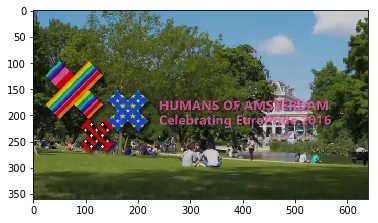

In [115]:
good_photos = cv2.cvtColor(snap[0], cv2.COLOR_BGR2BGRA)
plt.imshow(good_photos)

In [79]:
mse(snap[0],snap[5])

14999.475571289062